# SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper I'm replicating (the source of the dataset) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Get data

Since I'll be replicating the paper above (PubMed 200k RCT), the best is to  download the dataset they used.

That can be downloaded from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
# Clone github repository and list content
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
file_names = [data_dir + filename for filename in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  '''
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Read training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

How should the data look like? How I think the data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11
  },
   ...
]
```

A function which turns each of the datasets into the above format needs to be created so I can continue to prepare the data for modelling.

In [9]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  '''
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): # check to see if it is an ID line
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 692 ms, sys: 170 ms, total: 863 ms
Wall time: 910 ms


(180040, 30212, 30135)

In [11]:
# Check the first abstract of the training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


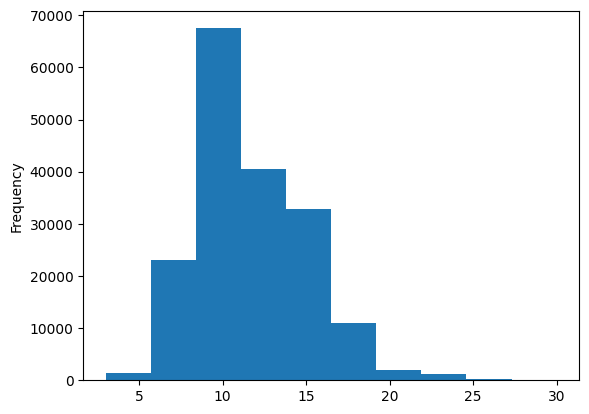

In [14]:
# Check the lenght of different lines
train_df.total_lines.plot.hist();

## Get list of sentences

In [15]:
# Convert abtract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Creating numeric lables

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract labels ('target column) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_enconder = LabelEncoder()
train_labels_encoded = label_enconder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_enconder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_enconder.transform(test_df['target'].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_enconder.classes_)
classes_names = label_enconder.classes_
num_classes, classes_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

## Model 0: Getting a baseline (TF-IDF Multinomial Naive Bayes classifier)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
from re import X
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
# Dowload helper functions util from Github's project repository
!wget https://raw.githubusercontent.com/aiwkz/skimlit-nlp/refs/heads/master/utils/helper_functions.py

--2024-11-21 12:36:58--  https://raw.githubusercontent.com/aiwkz/skimlit-nlp/refs/heads/master/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10019 (9.8K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.78K  --.-KB/s    in 0s      

2024-11-21 12:36:58 (27.0 MB/s) - ‘helper_functions.py.1’ saved [10019/10019]



In [24]:
# Calculate baseline results
from helper_functions import calculate_results

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Input, Conv1D, GlobalAveragePooling1D, Dense, GlobalMaxPool1D, Bidirectional, Concatenate, Dropout

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

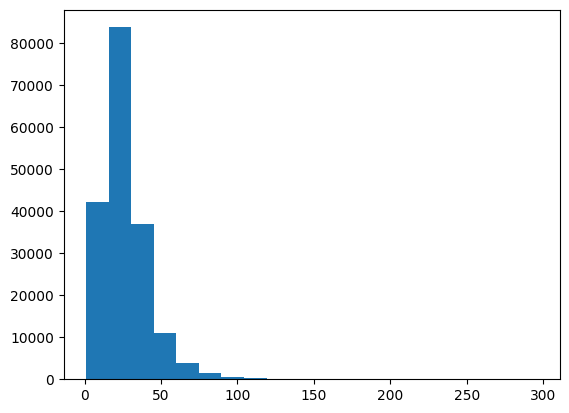

In [27]:
# What does the distribution looks like?
plt.hist(sent_lens, bins=20);

In [28]:
# How long of a sentences length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# What is the max length on the training set?
max(sent_lens)

296

### Create text vectorizer layer

In [30]:
# Set max for words from data vocabulary to use in training
max_tokens = 68000

In [31]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)
print(f'Text: {target_sentence}\n')
print(f'Length: {len(target_sentence.split())}\n')
print(f'Vectorized: {text_vectorizer([target_sentence])}\n')

Text: treatment of women at risk for preterm birth with repeat doses of glucocorticoids reduces neonatal morbidity but could have adverse long-term effects on cardiometabolic health in offspring .

Length: 28

Vectorized: [[  19    4   90   15   73   11 1184  770    7 2157  321    4 5286  827
  1083  807   72  281   99  118  335   71   18 3364   97    5 4109    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]



In [34]:
# How many words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [36]:
# Create token embedding layer
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='toke_ambedding')

In [37]:
# Show embedding example
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 treatment of women at risk for preterm birth with repeat doses of glucocorticoids reduces neonatal morbidity but could have adverse long-term effects on cardiometabolic health in offspring .

Sentence after vectorization:
 [[  19    4   90   15   73   11 1184  770    7 2157  321    4 5286  827
  1083  807   72  281   99  118  335   71   18 3364   97    5 4109    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.04986448  0.04803276  0.04910805 ...  0.00271501 -0.00785188
    0.00060449]
  [ 0.03147325  0.03108779 -0.01164142 ... -0.02374482 -0.02317882
    0.03700094]
  [ 0.00716678 -0.01559292  0.02790078 ...  0.0333224   0.03215582
   -0.03443702]
  ...
  [-0.00060399  0.01428564  0.03946934 ...  0.03941603  0.03700812
    0.02726164]
  [-0.00060399  0.01428564  0.03946934 ...  0.03941603  0.03700812
    0.02726164]
  [-0.00060

## Creating datasets (make sure data loads as fast as possible)

In [38]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [40]:
# Create 1D conv model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [41]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ toke_ambedding (Embedding)           │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 67s 116ms/step - accuracy: 0.5197 - loss: 1.1600 - val_accuracy: 0.7400 - val_loss: 0.6929
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 67s 119ms/step - accuracy: 0.7450 - loss: 0.6859 - val_accuracy: 0.7723 - val_loss: 0.6331
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 61s 109ms/step - accuracy: 0.7698 - loss: 0.6235 - val_accuracy: 0.7856 - val_loss: 0.5928


In [43]:
# Evaluate on whole validation set
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7867 - loss: 0.5979


[0.5992074608802795, 0.7869389653205872]

In [44]:
# Make predictions for each class
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


array([[4.5815852e-01, 1.6444556e-01, 8.7445281e-02, 2.6077551e-01,
        2.9175108e-02],
       [3.7938279e-01, 3.5185540e-01, 9.0251025e-03, 2.4926014e-01,
        1.0476473e-02],
       [1.5251483e-01, 7.9391859e-03, 2.6044289e-03, 8.3691061e-01,
        3.0909308e-05],
       ...,
       [1.3942953e-05, 9.3298370e-04, 7.7337481e-04, 6.2828794e-06,
        9.9827337e-01],
       [4.0443730e-02, 4.2809260e-01, 8.2807258e-02, 4.7836140e-02,
        4.0082029e-01],
       [1.9442567e-01, 6.4253986e-01, 4.1636311e-02, 6.2894337e-02,
        5.8503810e-02]], dtype=float32)

In [45]:
# Convert pred probs to labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.69389646498081,
 'precision': 0.7833429505990783,
 'recall': 0.7869389646498081,
 'f1': 0.7844408998989166}

In [47]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

In [48]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [49]:
# Test the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}\n')
use_embedded_setence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n {use_embedded_setence[0][:30]}')

Random sentence:
 serotonin reuptake inhibitors ( ssris ) are commonly prescribed off-label for children with autism .

Sentence after embedding:
 [ 0.01408427  0.05186386  0.07104737 -0.05050204 -0.05135608  0.05284046
 -0.02225833  0.00875366 -0.07198109 -0.00830762  0.07906838 -0.07230141
  0.00574835 -0.01071107  0.02906949 -0.07845169 -0.0791387  -0.00682883
 -0.05307952  0.01018662 -0.05231158 -0.04316125  0.03211369  0.01626727
  0.01908167  0.0708804   0.05699662  0.02147889 -0.02159834  0.0319902 ]


## Building and fitting an NLP feature extraction model using pretrained embeddings

In [50]:
# Create model
inputs = Input(shape=(), dtype=tf.string, name="input_text")
pretrained_embedding = tf.keras.layers.Lambda(
    lambda x: tf_hub_embedding_layer(x),
    output_shape=(512,)
)(inputs)
x = Dense(128, activation='relu')(pretrained_embedding)
outputs = Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs,
                         outputs,
                         name='model_2_USE_feature_extractor')

# Compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Fit model_2 to the training data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5937 - loss: 1.0915 - val_accuracy: 0.6895 - val_loss: 0.7956
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7035 - loss: 0.7712 - val_accuracy: 0.7118 - val_loss: 0.7563
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7145 - loss: 0.7566 - val_accuracy: 0.7164 - val_loss: 0.7262


In [53]:
# Evaluate on whole validation set
model_2.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7135 - loss: 0.7400


[0.7417432069778442, 0.713954746723175]

In [54]:
# Make predictions for each class
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step


array([[4.2484409e-01, 3.8318634e-01, 1.6980316e-03, 1.8370576e-01,
        6.5656523e-03],
       [3.3816096e-01, 5.1616186e-01, 3.8325677e-03, 1.3953969e-01,
        2.3048921e-03],
       [2.4575810e-01, 1.6071297e-01, 1.8308775e-02, 5.3613532e-01,
        3.9084665e-02],
       ...,
       [1.8322836e-03, 6.0906159e-03, 5.2086275e-02, 9.2583272e-04,
        9.3906504e-01],
       [4.4900347e-03, 4.7772087e-02, 2.1031918e-01, 1.6985532e-03,
        7.3572016e-01],
       [1.4700398e-01, 1.9889505e-01, 5.8331662e-01, 5.4018497e-03,
        6.5382510e-02]], dtype=float32)

In [55]:
# Convert pred probs to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [56]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.39547199788163,
 'precision': 0.7141221676221307,
 'recall': 0.7139547199788163,
 'f1': 0.7106214075894282}

In [57]:
model_1_results

{'accuracy': 78.69389646498081,
 'precision': 0.7833429505990783,
 'recall': 0.7869389646498081,
 'f1': 0.7844408998989166}

In [58]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

### Create character-level tokenizer

In [59]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [60]:
# Create function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

's e r o t o n i n   r e u p t a k e   i n h i b i t o r s   (   s s r i s   )   a r e   c o m m o n l y   p r e s c r i b e d   o f f - l a b e l   f o r   c h i l d r e n   w i t h   a u t i s m   .'

In [61]:
# Turn sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# What is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

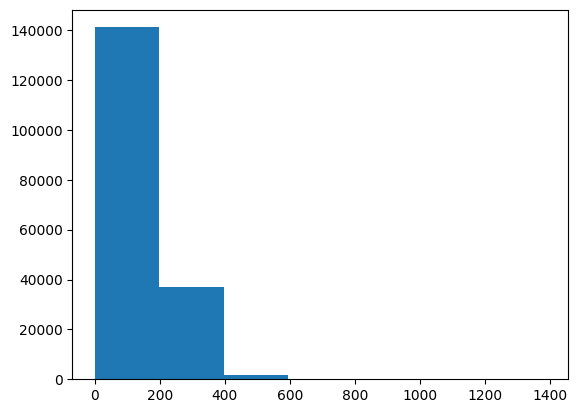

In [63]:
# Check distribution of sequences at a character-level
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [67]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [68]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in characters vocab: {len(char_vocab)}')
print(f'5 most common characters in vocab: {char_vocab[:5]}')
print(f'5 least common characters in vocab: {char_vocab[-5:]}')

Number of different characters in characters vocab: 28
5 most common characters in vocab: ['', '[UNK]', 'e', 't', 'i']
5 least common characters in vocab: ['k', 'x', 'z', 'q', 'j']


In [69]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 i n t e r n a l   v a l i d a t i o n   w a s   p e r f o r m e d   u s i n g   b o o t s t r a p p i n g   i n   t h e   t r a i n i n g   c o h o r t   a n d   a s s e s s i n g   t h e   d i s c r i m i n a t i o n   a n d   e x p l a i n e d   v a r i a t i o n   o f   t h e   m o d e l   i n   t h e   v a l i d a t i o n   c o h o r t   .

Length of random_train_chars: 149

Vectorized chars:
 [[ 4  6  3  2  8  6  5 12 21  5 12  4 10  5  3  4  7  6 20  5  9 14  2  8
  17  7  8 15  2 10 16  9  4  6 18 22  7  7  3  9  3  8  5 14 14  4  6 18
   4  6  3 13  2  3  8  5  4  6  4  6 18 11  7 13  7  8  3  5  6 10  5  9
   9  2  9  9  4  6 18  3 13  2 10  4  9 11  8  4 15  4  6  5  3  4  7  6
   5  6 10  2 24 14 12  5  4  6  2 10 21  5  8  4  5  3  4  7  6  7 17  3
  13  2 15  7 10  2 12  4  6  3 13  2 21  5 12  4 10  5  3  4  7  6 11  7
  13  7  8  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Create a character-level embedding

In [70]:
# Create char embedding layer
char_embed = Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embed')

In [71]:
# Test character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 i n t e r n a l   v a l i d a t i o n   w a s   p e r f o r m e d   u s i n g   b o o t s t r a p p i n g   i n   t h e   t r a i n i n g   c o h o r t   a n d   a s s e s s i n g   t h e   d i s c r i m i n a t i o n   a n d   e x p l a i n e d   v a r i a t i o n   o f   t h e   m o d e l   i n   t h e   v a l i d a t i o n   c o h o r t   .

Embedded chars (after vectorization and embedding):
 [[[ 0.04672046 -0.04399547 -0.01394104 ... -0.02946571  0.04361102
   -0.01930579]
  [-0.04816054  0.00120164  0.00765536 ... -0.00018696  0.04052121
   -0.01225468]
  [ 0.02127391 -0.00116712 -0.02204126 ... -0.02019062 -0.04944554
   -0.00624172]
  ...
  [-0.031886    0.01588533 -0.04741036 ...  0.00945878  0.02204717
   -0.00953522]
  [-0.031886    0.01588533 -0.04741036 ...  0.00945878  0.02204717
   -0.00953522]
  [-0.031886    0.01588533 -0.04741036 ...  0.00945878  0.02204717
   -0.00953522]]]

Character embedding shape: (1, 290, 25)


## Build a Conv1D model to fit on character embeddings

In [72]:
# Create model
inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedings = char_embed(char_vectors)
x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedings)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_3_conv1d_embeddings')

# Compile model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [73]:
# Summary
model_3.summary()

Model: "model_3_conv1d_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.4318 - loss: 1.3873 - val_accuracy: 0.5888 - val_loss: 1.0403
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5965 - loss: 1.0212 - val_accuracy: 0.6373 - val_loss: 0.9344
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6358 - loss: 0.9285 - val_accuracy: 0.6546 - val_loss: 0.8796


In [76]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


array([[0.13662189, 0.59129864, 0.06993449, 0.13123219, 0.07091278],
       [0.11304635, 0.48468995, 0.00673985, 0.3852789 , 0.01024489],
       [0.09800725, 0.09277599, 0.06649435, 0.7095979 , 0.03312441],
       ...,
       [0.04375097, 0.08161657, 0.08358539, 0.08399449, 0.7070525 ],
       [0.04560858, 0.20868501, 0.30112624, 0.11009555, 0.3344846 ],
       [0.3407409 , 0.40002578, 0.1632666 , 0.07714303, 0.01882369]],
      dtype=float32)

In [77]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [78]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.7950483251688,
 'precision': 0.6547184532157708,
 'recall': 0.657950483251688,
 'f1': 0.6464481226820903}

In [79]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [80]:
# 1. Setup token inputs/model
token_inputs = Input(shape=(), dtype=tf.string, name='token_input')
token_embeddings = tf.keras.layers.Lambda(
    lambda x: tf_hub_embedding_layer(x),
    output_shape=(512,)
)(token_inputs)
token_outputs = Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(layers.LSTM(25))(char_embedings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128, activation='relu')(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.inputs],
                         outputs=output_layer,
                         name='model_4_token_car_embeddings')

In [81]:
# Summary
model_4.summary()

Model: "model_4_token_car_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ char_embed[1][0],      │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         22,912 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,121 (391.10 KB)

 Trainable params: 100,121 (391.10 KB)

 Non-trainable params: 0 (0.00 B)

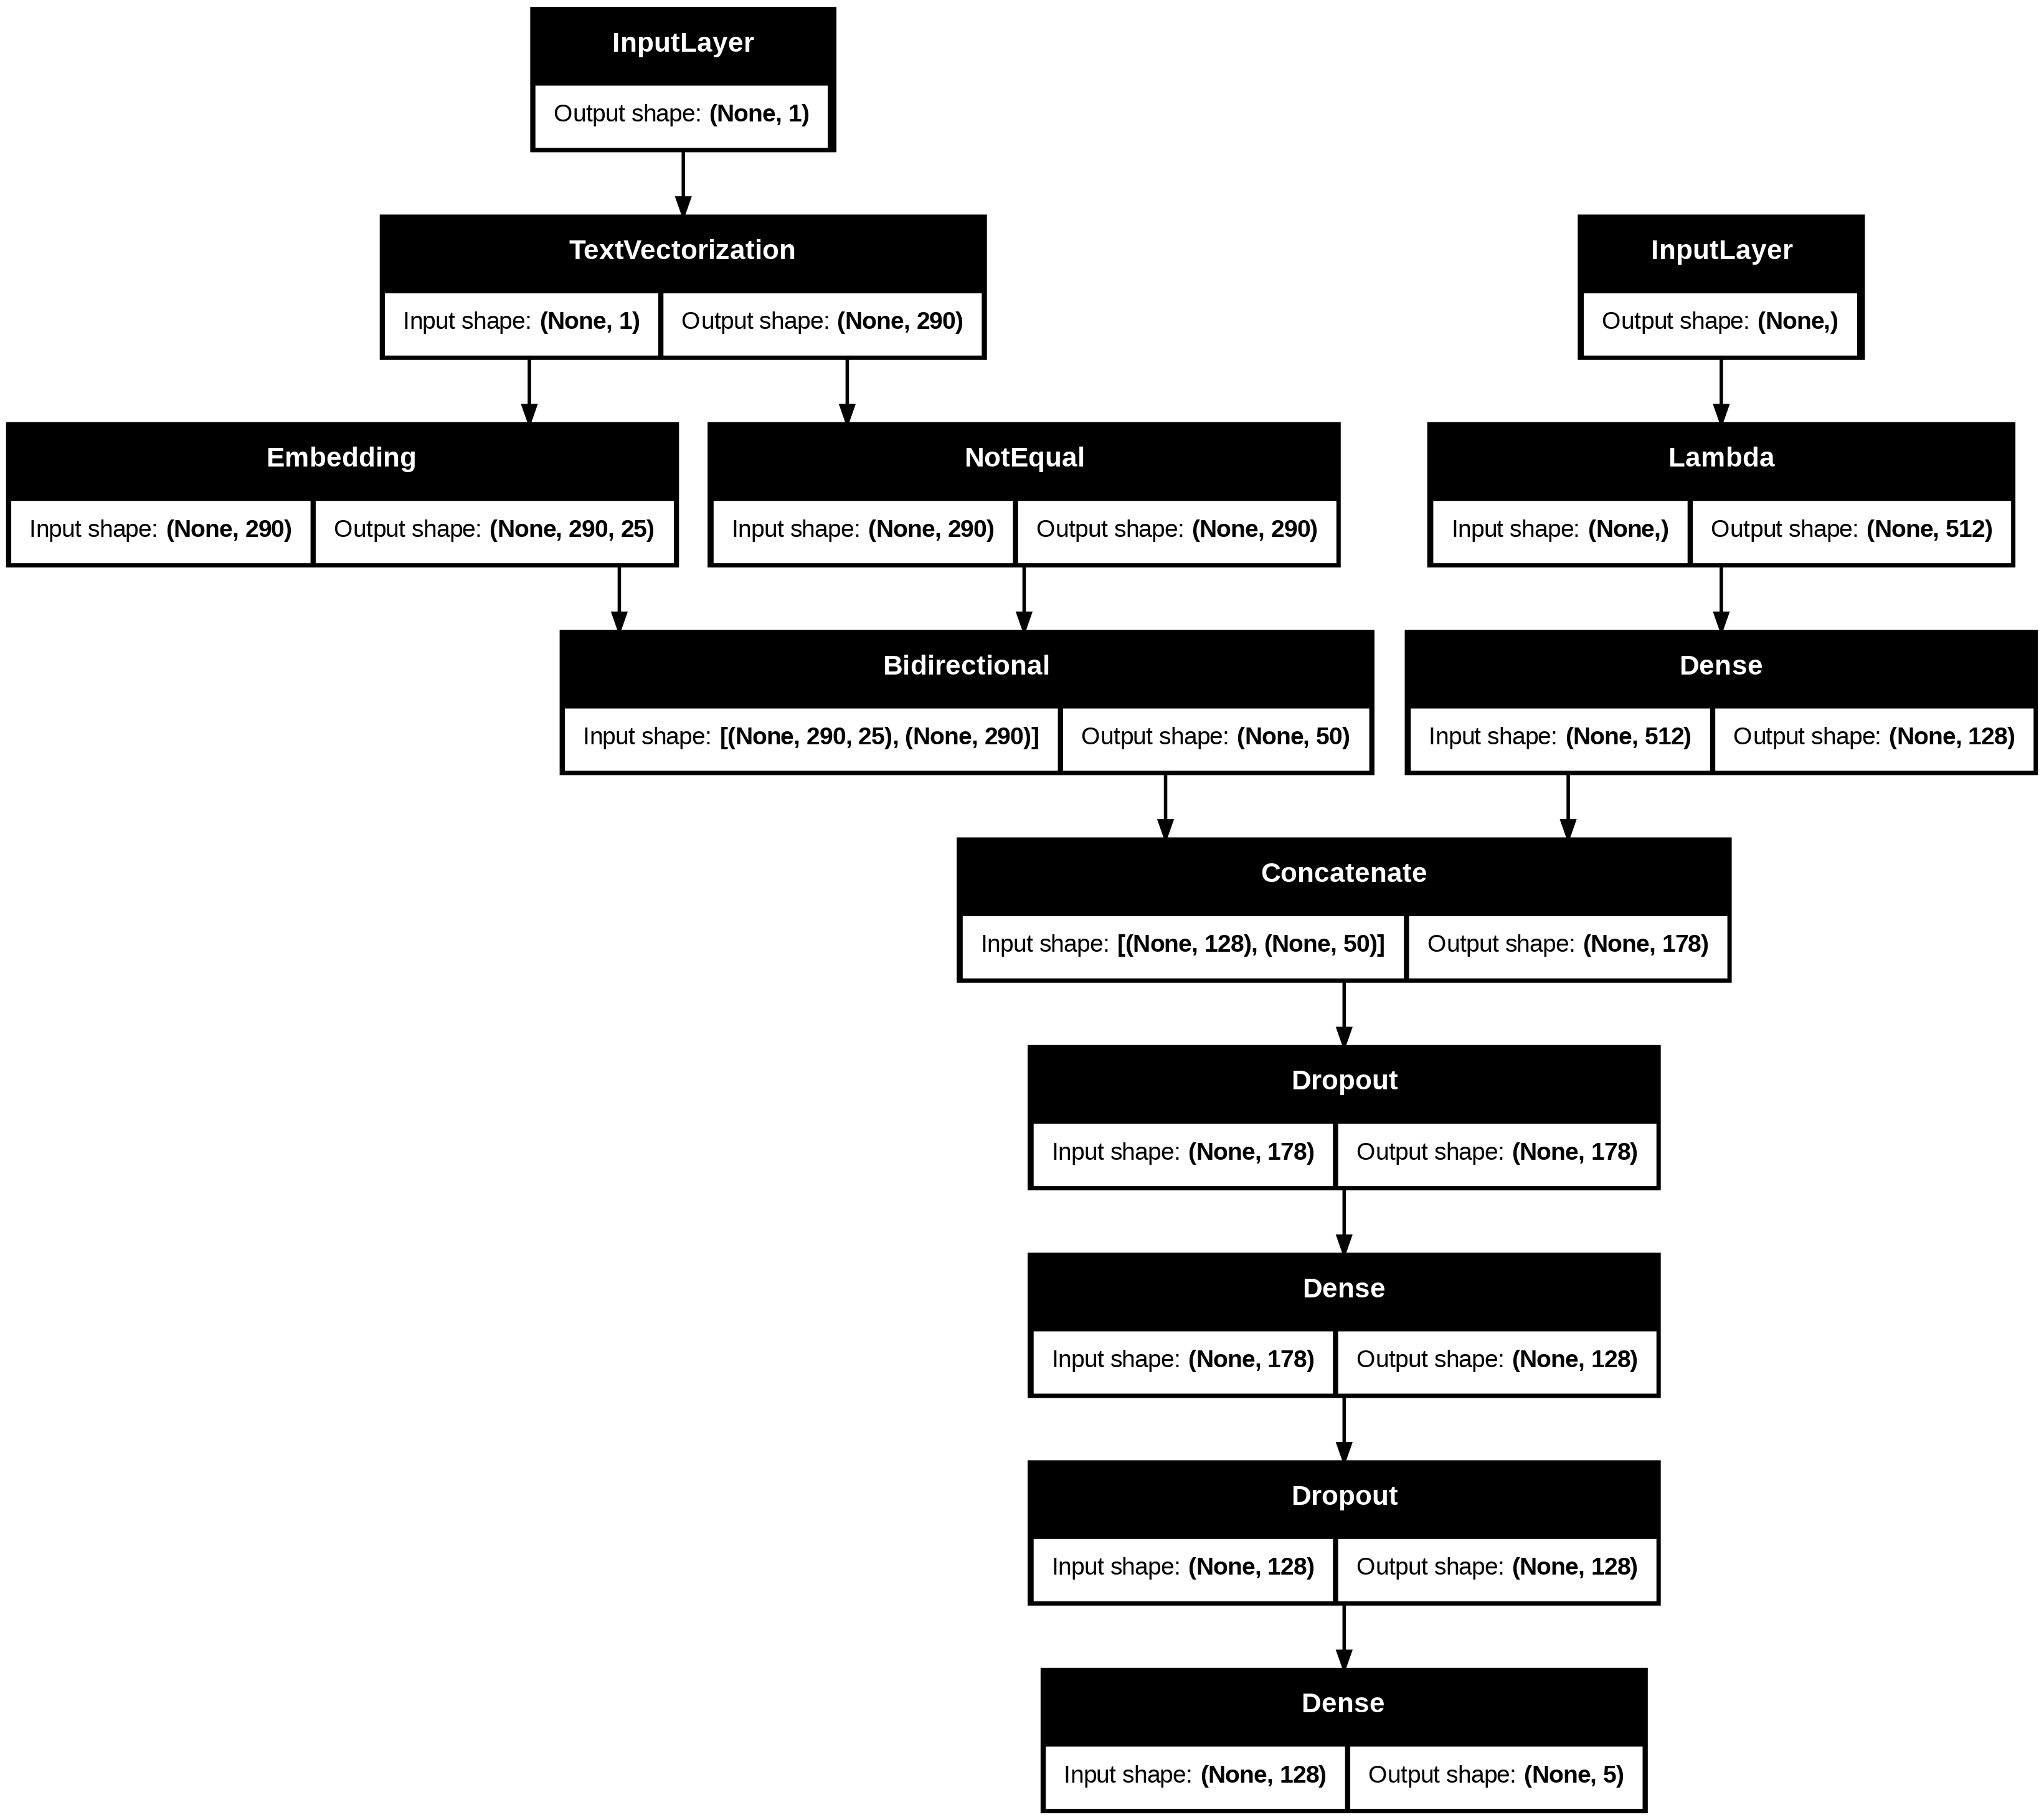

In [82]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [83]:
# Compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [84]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Repeat the above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting model on token and character-level sequences

In [87]:
# Fit model
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 229s 393ms/step - accuracy: 0.5252 - loss: 1.1537 - val_accuracy: 0.6991 - val_loss: 0.7885
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 212s 376ms/step - accuracy: 0.6881 - loss: 0.8145 - val_accuracy: 0.7277 - val_loss: 0.7262
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 213s 379ms/step - accuracy: 0.6978 - loss: 0.7785 - val_accuracy: 0.7301 - val_loss: 0.6979


In [88]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.7293 - loss: 0.7038


[0.7053377628326416, 0.7288825511932373]

In [89]:
# Make predictions using the token-character model hybird
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 80s 84ms/step


array([[4.2766267e-01, 3.6146593e-01, 8.6251600e-03, 1.9385931e-01,
        8.3868019e-03],
       [4.0660036e-01, 3.7849909e-01, 5.0363485e-03, 2.0879245e-01,
        1.0717519e-03],
       [2.5743198e-01, 7.4358113e-02, 4.0561724e-02, 6.0813540e-01,
        1.9512784e-02],
       ...,
       [8.7681814e-04, 1.0509607e-02, 5.3854674e-02, 2.0221702e-04,
        9.3455672e-01],
       [4.2758365e-03, 5.0626807e-02, 1.9032079e-01, 1.2780633e-03,
        7.5349849e-01],
       [3.0804920e-01, 3.7961370e-01, 2.1201970e-01, 4.2945221e-02,
        5.7372224e-02]], dtype=float32)

In [90]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [91]:
# Calculate results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.88825632199126,
 'precision': 0.7294491933083215,
 'recall': 0.7288825632199126,
 'f1': 0.726867350459917}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [92]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [93]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

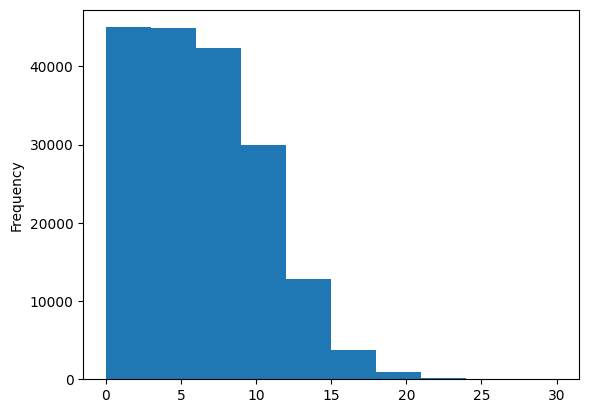

In [94]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [96]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


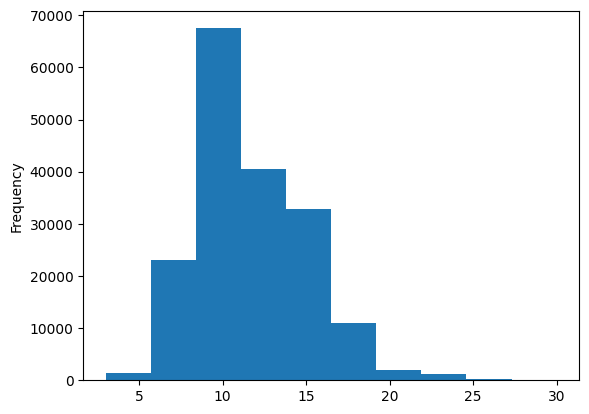

In [97]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [98]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [99]:
# Use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [100]:
# 1. Token inputs
token_inputs = Input(shape=(), dtype='string', name='token_inputs')
token_embeddings = tf.keras.layers.Lambda(
    lambda x: __import__('tensorflow_hub').KerasLayer(
        'https://tfhub.dev/google/universal-sentence-encoder/4', trainable=False
    )(x),
    output_shape=(512,),
    name='use_embedding_lambda'
)(token_inputs)
token_outputs = Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = Input(shape=(1, ), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                       char_model.output])

z = Dense(256, activation='relu')(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                          total_lines_model.output,
                                                                          z])

# 7. Create output layer
output_layer = Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer,
                                 name='model_5_tribrid_embedding_model')

In [101]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ use_embedding_lambda      │ (None, 512)            │              0 │ token_inputs[0][0]     │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 290)            │              0 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         65,664 │ use_embedding_lambda[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 48)             │          9,600 │ char_embed[2][0],      │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid_embedd… │ (None, 176)            │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_positional_em… │ (None, 320)            │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ dense_9[0][0],         │
│                      

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

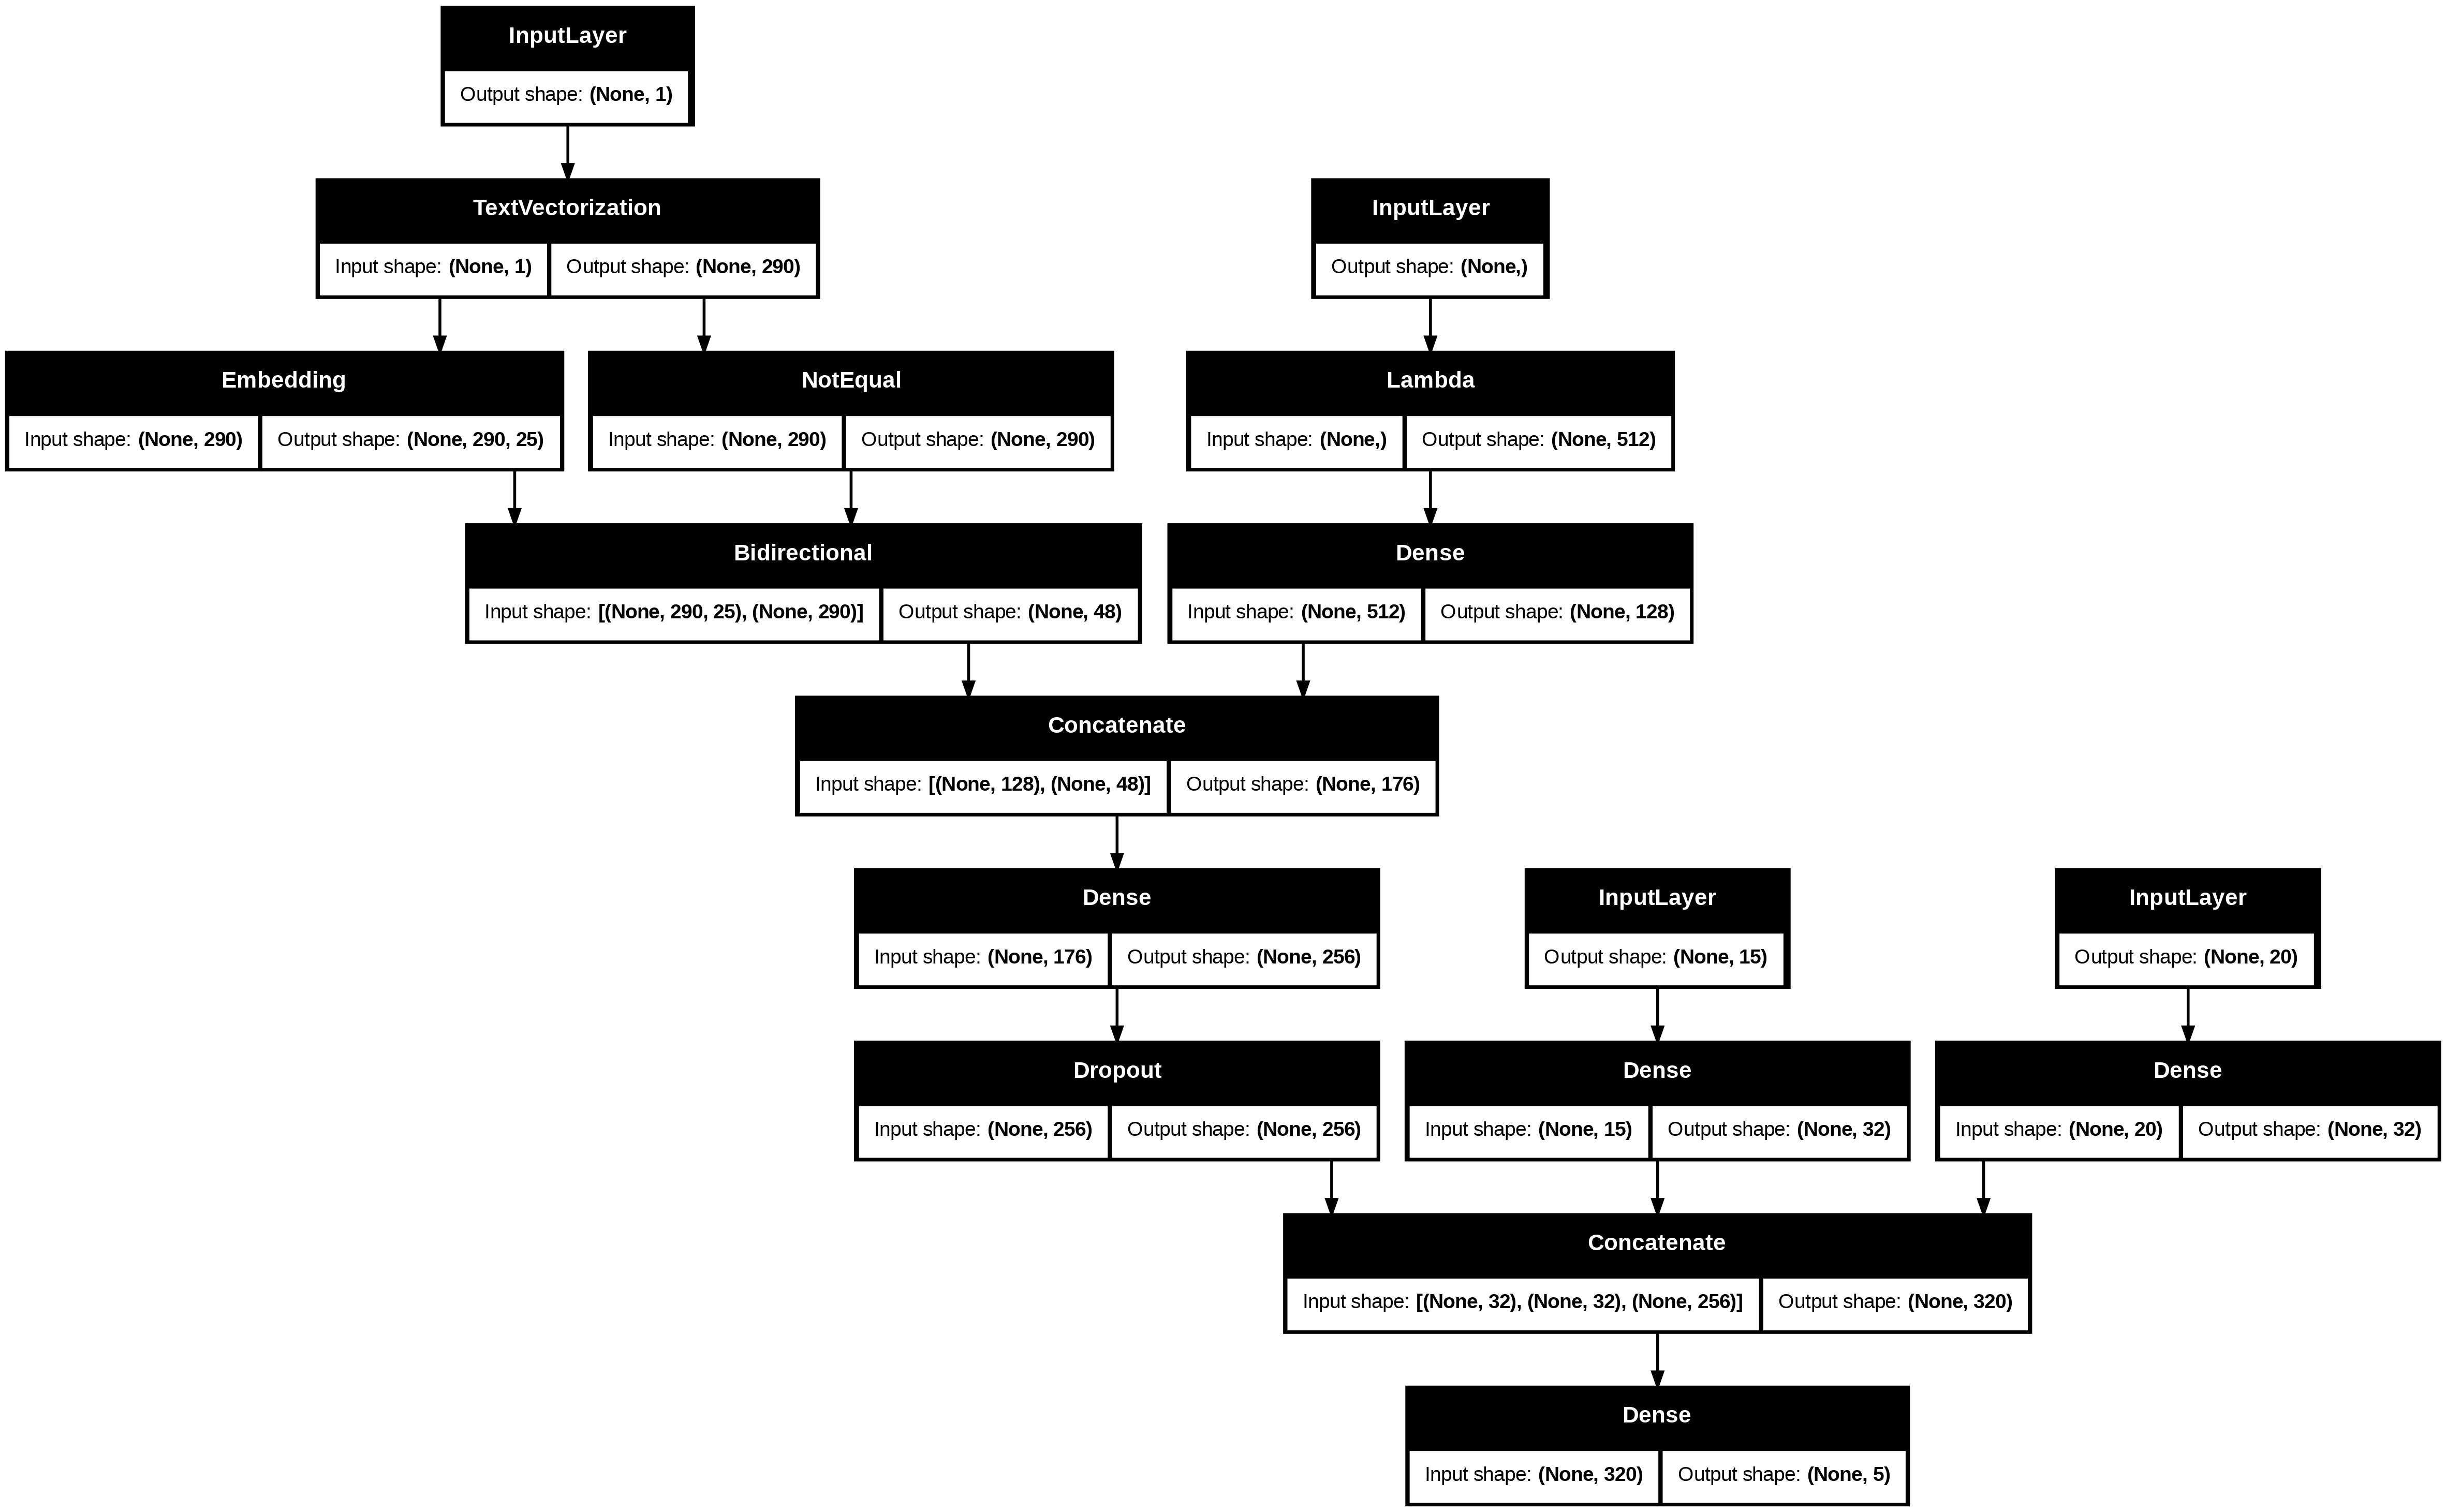

In [102]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [103]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [104]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [105]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predicitions with tribrid model

In [106]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 247s 387ms/step - accuracy: 0.6272 - loss: 1.2221 - val_accuracy: 0.8078 - val_loss: 0.9803
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 211s 375ms/step - accuracy: 0.8123 - loss: 0.9670 - val_accuracy: 0.8241 - val_loss: 0.9371
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 208s 371ms/step - accuracy: 0.8224 - loss: 0.9542 - val_accuracy: 0.8348 - val_loss: 0.9316


In [107]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 91s 85ms/step


array([[0.5146112 , 0.11260436, 0.01062848, 0.3437085 , 0.01844746],
       [0.56571484, 0.08442171, 0.05252789, 0.28691766, 0.01041788],
       [0.29727665, 0.11554472, 0.14056425, 0.36774555, 0.07886888],
       ...,
       [0.03247121, 0.08342785, 0.03554451, 0.02514121, 0.82341516],
       [0.02731202, 0.33159366, 0.08281397, 0.02351213, 0.5347682 ],
       [0.15472737, 0.64621943, 0.09180462, 0.0405512 , 0.0666974 ]],
      dtype=float32)

In [108]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [109]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.64888123924268,
 'precision': 0.8351899039336046,
 'recall': 0.8364888123924269,
 'f1': 0.8353861920482704}

## Compare model results

In [110]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.693896,0.783343,0.786939,0.784441
model_2_pretrained_token_embedding,71.395472,0.714122,0.713955,0.710621
model_3_custom_char_embedding,65.795048,0.654718,0.657950,0.646448
model_4_hybrid_char_token_embedding,72.888256,0.729449,0.728883,0.726867
model_5_pos_char_token_embedding,83.648881,0.835190,0.836489,0.835386


In [111]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

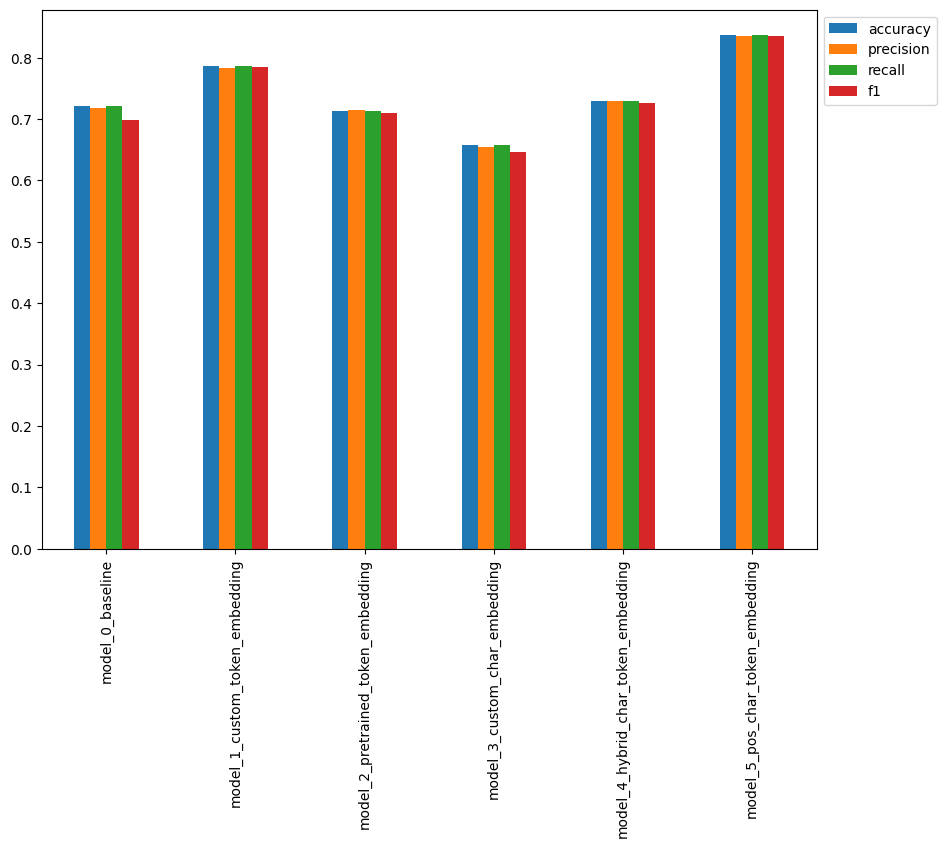

In [112]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

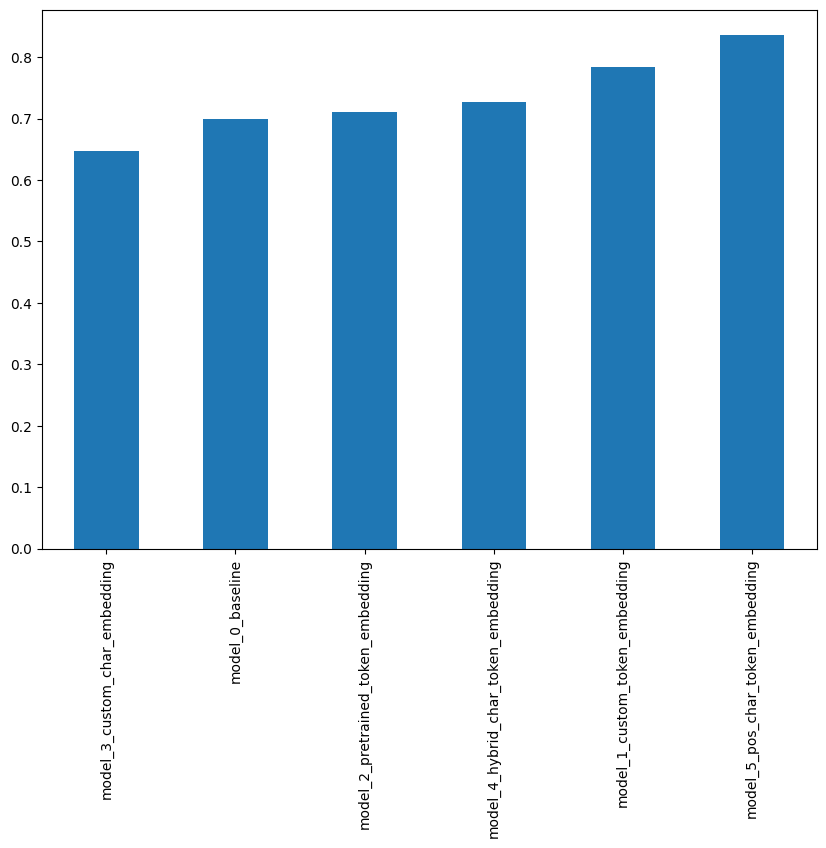

In [113]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7));

## Save model

In [114]:
# Save the best performing model to SavedModel format (default)
model_5.save('skimlit_tribrid_model.keras')